# Transfer learning for computer vision tutorial

전이학습

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load Data
해당 example 에서는 개미와 벌을 구분하는 모델을 만든다. 준비된 데이터는 각 120개의 벌과 개미 이미지이다. 각 클래스당 75개의 validation image가 있다. Transfer learning에 사용될 것이다.

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [4]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

In [5]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: data/hymenoptera_data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: data/hymenoptera_data\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [6]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [7]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1b80be4a508>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1b80b82fd48>}

In [10]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
dataset_sizes

{'train': 244, 'val': 153}

In [11]:
class_names = image_datasets['train'].classes
class_names

['ants', 'bees']

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize a few images
data augmentations 확인을 위해 몇개의 데이터를 찍어본다.

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if title is not None:
        plt.title(title)
    plt.imshow(inp)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

In [16]:
out.size()

torch.Size([3, 228, 906])

In [17]:
inputs.size()

torch.Size([4, 3, 224, 224])

In [23]:
class_names

['ants', 'bees']

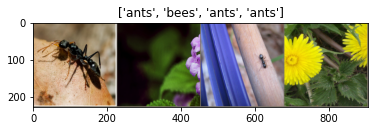

In [24]:
imshow(out, title=[class_names[x] for x in classes])

In [27]:
inp = inputs.clone()
inp = inp.numpy().transpose((0,2,3,1))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

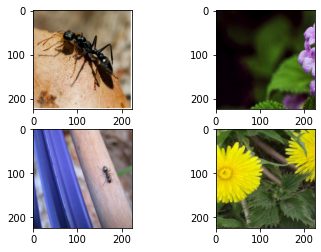

In [32]:
inp.shape
fig, axs = plt.subplots(2,2)
axs[0, 0].imshow(inp[0])
axs[0, 1].imshow(inp[1])
axs[1, 0].imshow(inp[2])
axs[1, 1].imshow(inp[3])

## Finetuning the convnet
pretrained 된 모델을 불러와서 finetuning 한다.

In [33]:
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\user/.cache\torch\checkpoints\resnet18-5c106cde.pth


In [38]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
num_ftrs = model_ft.fc.in_features
num_ftrs

512

마지막 fully connected layer를 바꿔준다.

In [ ]:
model_ft.fc = nn.Linear(num_ftrs, 2)
